### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# CS 506 Group Assignment Optimization

#### Zijie (Jay) Wang (zwang688@wisc.edu)


*****

### Table of Contents

## 1. Introduction

CS 506 (Software Engineering) is one of the most popular undergraduate computer science courses in UW-Madison. In this course, students are expected to finish one large programing project in groups through the whole semester. Thus, wisely assigning groups is critical for instructors. Our goal in this project is to design a robust and flexible optimization model to improve the group assignment process. It will make teaching more effective and the learning experience more enjoyable. We have interviewed Professor Ben Liblit, the instructor for CS 506 in Spring 2018, and this model is tailored to fit his requirement and the data he is using.

**CS 506 Group Assignment Process**
1. All students are required to submit one project proposal in the first two weeks.
2. The instructor and TA's choose about one third of the proposals for billing.
3. In the billing phase, students read all selected proposals and complete a survey regarding to his/her preference, and previous programming experience.
4. Instructor assign students to groups based on the survey results.

In the survey, Liblit asks students to rank $8$ most interested projects, $3$ most desired teammates, and $2$ students who they do not want to work with. He also collects data regarding to student's previous project complexity and life time programming experience, measured by lines of code. For the confidentiality reason, Liblit did not share those data with us. We [generated](#6.1-Demo-data-generation) fake data having the similar format for this project. Within each step, Liblit has specific requirements (i.e. group size). These requirement will be discussed in detail in the [constraints](#2.3.-Constraints) section.

Liblit would like to assign students to their interested projects or groups having their friends. On the other hand, he expects each groups to have a similar programing experience level. In this project, we consider two objectives, student happiness and group experience equality. We propose there is a trade-off relationship between two objectives. We will design the model in a way that instructors can easily change the weights of objectives and each single factors.

Currently, Liblit is using an optimization model, written by graduate students in GAMS years ago, with preset parameters. He didn't tell us details about that method, and our goal is to make a more flexible model which can solve the same CS 506 group assignment problem.

**Source:** *Ben Liblit, personal communication, April 18, 2018.*

## 2. Mathematical Model ##

In this section, we will discuss how to transfer the constraints and objectives into mathematical form. For the sake of convenience, we define $\mathcal{I}$ as the set containing labels of all student enrolled in CS506, and $\mathcal{J}$ as the set of all projects which are selected for billing. 

### 2.1. Modeling Assumptions

- In this problem, we are assigning students into groups, so we expect integer solutions.
- We assume the given data are cleaned. Our model can handle `NA` data, but we assume there are no errors in the data (like one proposal is submitted by two students).

### 2.2. Decision Variables

The decision variable is a matrix $A \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{J} \Vert}\left(\text{Bin}\right)$.

$$
A_{i,j}=\begin{cases}
           1 &\text{If student $i$ is assigned to project $j$}\\
           0 &\text{Otherwise}
        \end{cases}
$$

### 2.3. Constraints

- **Group Size Constraint**

    Each group can only have $l$ to $u$ ($l, u \in \mathbb{N}, u > l$) members, where $i, j$ are decided by the instructor. However, some projects will be discarded in this assignment, so each project should have variable size either $0$ or $l$ to $u$.
    
    For example, there are $90$ students enrolled in CS506 in 2018 Spring, and TA's have chosen $29$ candidate project proposals. Each project requires at least $5$ students. It implies there are at most $18$ final projects, and at least $11$ project will be discarded. 
    
    In other words, $$\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} = 0 \quad \text{or} \quad  l \leq \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq u$$

    To model the variable lower bound, we introduce a new binary vector decision variable $z_1 \in M_{\Vert \mathcal{J} \Vert \times 1}\left(\text{Bin}\right)$.
    
    Then, this constraint becomes,
    $$\forall j \in \mathcal{J}, \quad l z_{1_j} \leq \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq u z_{1_j}$$
    
<a id='constraints'></a>
- **Student Choice Constraint**

    Each student will be assigned to exactly one group,
    $$\forall i \in \mathcal{I}, \quad \sum_{j=1}^{\Vert \mathcal{J} \Vert}A_{i,j} = 1$$
    
- **Proposal Writer Constraint**

    The instructor of CS506 made a rule that the person who submits the proposal must be working on his/her submitted project, if it won the bidding. 
    
    We define a discrete injective function $F_w: \mathcal{J} \mapsto \mathcal{I}$ to map each project to its writer. Then, we can model this constraint as a logical constraint,
    
    $$\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \geq 1 \longrightarrow A_{F_w\left(j\right), j} = 1$$
    
    We need to introduce another binary vector variable $z_2 \in M_{\Vert \mathcal{J} \Vert \times 1}\left(\text{Bin}\right)$ as the intermediate state variable.
    
    $$
    \forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \geq 1 \longleftrightarrow z_{2_{j}} = 1\\
    $$
    
    One upper bound of $\sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j}$ is $u$, and one lower bound of $\sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} - 1$ is $-1$. Then, using the Big-M method we can model the above relationship as,
    
    $$
    \forall j \in \mathcal{J}, \quad \begin{cases}
        \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} &\leq z_{2_{j}} u \\
        \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} -1 &\geq -1 \left(1 - z_{2_{j}}\right) \quad \text{or} \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} &\geq z_{2_{j}}
    \end{cases}
    $$
    
    Then, the original constraint becomes,
    
    $$\forall j \in \mathcal{J}, \quad z_{2_{j}} = 1 \longrightarrow A_{F_w\left(j\right), j} = 1$$
    
    It can be modeled as,
    
    $$\forall j \in \mathcal{J}, \quad z_{2_{j}} \leq A_{F_w\left(j\right), j}$$

### 2.4. Objective Function

At the beginning of the billing phase, all students in CS506 are asked to complete a background survey. We can use the information to define the following five discrete surjective functions.

1. $F_1: \mathcal{I} \mapsto \{1, 2, 3, 4, 5\}$, mapping each student to the scale of the most complicated project he/she has done.
2. $F_2: \mathcal{I} \mapsto \{1, 2, 3, 4, 5\}$, mapping each student to the level of his/her lifetime programming experience.
3. $F_3: \mathcal{I} \mapsto \mathcal{J}^8$, mapping each student to an ordered 8-tuple of project numbers that he/she is interested.
4. $F_4: \mathcal{I} \mapsto \mathcal{I}^3$, mapping each student to an ordered 3-tuple of students who he/she wants to work with.
5. $F_5: \mathcal{I} \mapsto \mathcal{I}^2$, mapping each student to an ordered 2-tuple of students who he/she does not want to work with.

We can also introduce a weight value for each of the function above, to indicate the importance level for each measure. In this model, we assume all weights are fixed and given by the instructor.

1. $\beta_1 \in \mathbb{R}:$ scalar weight of $F_1$.
2. $\beta_2 \in \mathbb{R}:$ scalar weight of $F_2$.
3. $\beta_3 \in \mathbb{R}^8:$ an ordered 8-tuple weight of $F_3$.
4. $\beta_4 \in \mathbb{R}^3:$ an ordered 3-tuple weight of $F_4$.
5. $\beta_5 \in \mathbb{R}^2:$ an ordered 2-tuple weight of $F_5$.

All weights $\beta_1, \dots, \beta_5$ can be positive or negative, but usually we only want $\beta_5$ to be the penalty (negative).


Taking advantage of the fact that all decision variables are binary and $\mathcal{I}$ being determinative and finite, we can vectorize these mappings to make the transformations of $A$ become easy linear algebra. To make the notations simple, we use the same notation $\left(F_1,\dots, F_5\right)$ for the vectorized functions. The specific vectorization is discussed in the section below.

For our model, we consider the fairness score $\left(O\right)$ as a linear combination of equality score $\left(D\right)$ and student happiness score $\left(H\right)$. We assume only $F_1$ and $F_2$ contribute to the programing experience equality of each group, and only $F_3, F_4, F_5$ contribute to the student happiness of their group assignments.

- **Experience Equality**

    Experience Equality means we want each group to have a similar average programing experience. We can first vectorize functions $F_1, F_2$ into two column vectors with length $\Vert \mathcal{I} \Vert$, where $F_1^{\left( i \right)}, F_2^{\left( i \right)}$ corresponds to the two experience measurements of student $i$. Then, we can write all $\Vert \mathcal{J} \Vert$ groups' average experience level $\left(E\right)$ with regarding to the weights $\beta_1, \beta_2$,

    $$E = \text{diag}\left( A^T \times \vec{1} \right)^{-1} \left(A^T\left(\beta_1 F_1\right) + A^T\left(\beta_2 F_2\right)\right)$$

    It's worth mentioning that $\vec{1}$ is a length $\Vert \mathcal{I} \Vert$ column vector, where all values are $1$, so $A^T \times \vec{1}$ becomes a length $\Vert \mathcal{J} \Vert$ column vector of all group sizes. Then, $\text{diag}\left( A^T \times \vec{1} \right)^{-1}$ is a diagonal matrix whose diagonal is exactly the inverse of the group sizes. Finally, $E$ is a length $\Vert \mathcal{J} \Vert$ vector of the experience average of all groups.
    
    The programming experience equality $\left(D\right)$ then can be modeled as the variance of those averages. Denote $\overline{E}$ as the population mean of the group experience averages,

    $$\overline{E} = \frac{\sum_{k=1}^{\Vert \mathcal{J} \Vert} E_k}{\Vert \mathcal{J} \Vert}$$

    Then, we can write the variance as (note here we are using the population variance formula),
    
    $$
    \begin{align*}
    D &= \text{Var}\left(E \right)\\
        &= \frac{1}{\Vert \mathcal{J} \Vert}\sum_{k=1}^{\Vert \mathcal{J} \Vert}\left(E_k - \overline{E}\right)^2
    \end{align*}
    $$

<a id='relaxation'></a>
- **Experience Equality (Linear Relaxation)**
    
    In the set up above, it requires a very complicated (large) quadratic expression and solvers will take a very long time solely to set up the expression $D$. In this section, we propose a linear relaxation to encode the group experience equality into a linear constraint.
    
    Instead of minimizing the variance of experience means, we can constrain the experience average of each group into a range. The idea is similar to the robust LP we have discussed in the lecture.
    
    We first compute the overall experience mean regarding to the weights $\beta_1, \beta_2$,
    
    $$\overline{E_1} = \frac{\sum_{k=1}^{\Vert \mathcal{I} \Vert} \left(\beta_1  F_{1_k} + \beta_2 F_{2_k} \right)}{\Vert \mathcal{I} \Vert}$$
    
    Also compute the standard deviation $\left(\sigma\right)$ of $\left(\beta_1  F_{1_i} + \beta_2 F_{2_i}\right)$,
    
    $$\sigma = \sqrt{\frac{\sum_{k=1}^{\Vert \mathcal{I} \Vert} \left(\beta_1  F_{1_k} + \beta_2 F_{2_k} - \overline{E_1}\right)^2}{\Vert \mathcal{I} \Vert}}$$
    
    Note $\overline{E_1}$ and $\sigma$ are computed before solving the optimization problem. Then, we add the following constraint.
    
    $$
    \forall j \in \mathcal{J}, \quad \sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j} \left(\overline{E_1} - \delta_1 \sigma \right) \leq \left(A^T\left(\beta_1 F_1\right) + A^T\left(\beta_2 F_2\right)\right)_j \leq \quad \sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j} \left(\overline{E_1} + \delta_1 \sigma \right)
    $$
    
    In the above inequality, $\left(A^T\left(\beta_1 F_1\right) + A^T\left(\beta_2 F_2\right)\right)_j $ is the weighted total experience level of group $j$. $\sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j}$ is the group size of group $j$. $\left(\overline{E_1} - \delta_1 \sigma \right)$ is a lower bound regarding to the experience mean and standard deviation, where $\delta_1$ determines the tolerant level. If $\delta_1$ is too large, the constraint becomes meaningless, and if it is too small, the model can become infeasible. It requires the instructor to tune this parameter. Finally, $\left(\overline{E_1} + \delta_1 \sigma \right)$ is the corresponding upper bound. The reason we times the size  $\sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j}$ on both sides is to avoid division which requires to use `@NLexpression`, and `JuMP.jl` doesn't support vector devisions.
    

<a id='happiness'></a>
- **Student Happiness**

    Student happiness is defined as the weighted matches of $F_3\left(\mathcal{I}\right), F_4\left(\mathcal{I}\right), F_5\left(\mathcal{I}\right)$ to student's real assignments. 

    For example, student $\mathcal{I}_p$ has an ordered list of projects $F_3\left(\mathcal{I}_p\right)=\begin{bmatrix}a_1\\a_2\\a_3\\q\\a_5\\a_6\\a_7\\a_8\end{bmatrix}$ he wants to work on, and sorted lists $F_4\left(\mathcal{I}_p\right) = \begin{bmatrix}b_1\\b_2\\b_3\end{bmatrix}$ and  $F_5\left(\mathcal{I}_p\right) = \begin{bmatrix}p_4\\c_2\end{bmatrix}$ of students he would like/ not like to be grouped with. He is assigned to group $q$ with other students $p_1, \dots, p_5$. Suppose he did rank $q$ as his fourth favorite project, $F_3^{\left(4\right)}\left(\mathcal{I}_p\right) = q$, then there is a happiness reward $\beta_3^{\left(4\right)}$ for him. All the students he wants to work with are not assigned to his group, and the student $p_3$, who he doesn't like, is in his group. Then, there is no happiness bonus from $F_4$ but a penalty $\beta_5^{\left(1\right)}$ from $F_5$.
    
    To make the algebraic expression simple, we can vectorize $F_3$ and $\theta_3$ (note they are all given) into a matrix $F_3 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{J} \Vert}\left(\beta_3\right)$.

    $$
    F_{3_{i,j}}=\begin{cases}
               \beta_3^{\left(p\right)} &\text{If student $i$ has listed project $j$ in his/her preference list with rank $p$}\\
               0  &\text{If project $j$ is not on the preference list of student $i$}
            \end{cases}\\
    $$
    
    The happiness reward from $F_3$ simply becomes (note $\circ$ is Hadamard multiplication, a.k.a the element-wise matrix multiplication),
    
    $$H_{F_3} = \sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j}$$
    
    <a id='f4'></a>We then vectorize $F_4$ and $\theta_4$ into a matrix $F_4 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{I} \Vert}\left(\beta_4\right)$.
    
    $$
    F_{4_{k,l}}=\begin{cases}
               \beta_4^{\left(p\right)} &\text{If student $k$ has listed student $l$ in his/her preference list with rank $p$}\\
               0  &\text{If student $l$ is not on the preference list of student $k$}
            \end{cases}\\
    $$
    
    By this [lemma 1](#lemma1) below, the happiness score from $F_4$ can be written as,
    
    $$H_{F_4} = \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k}$$
    
    Using the same way of $F_4$ to vectorize $F_5 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{I} \Vert}\left(\beta_5\right)$, the happiness penalty from $F_5$ becomes,
    
    $$H_{F_5} = \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}$$
    
    Finally, the total happiness score is,
    
    $$H = H_{F_3} + H_{F_4} + H_{F_5} =  \sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j} +  \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k} + \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}$$

- **Combination**

    Intuitively we think there is rather a trade-off relationship between course equality and student happiness. We can give them two trade-off parameters $\delta_1, \delta_2 \in \mathbb{R}$. We are trying to minimize the variance of experience levels, and maximize the student happiness. Therefore, we negate the first part of the objective and maximize the combination.
    
    Then the objective function $\left(O\right)$ is,
    
    $$
    \begin{align*}
    O &= -\delta_1 D + \delta_2 H \\
      &= -\delta_1 \frac{1}{\Vert \mathcal{J} \Vert}\sum_{k=1}^{\Vert \mathcal{J} \Vert}\left(E_k - \overline{E}\right)^2 + \delta_2 \left(\sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j} +  \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k} + \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}\right)
    \end{align*}
    $$
    
    We also can use the linear relaxed version. The objective of equal experience level is transformed into a linear constraint with $\delta_2$ embedded. Then, the only objective function $\left(O\right)$ is,
        
    $$
    \begin{align*}
    O &= \delta_2 H = \delta_2 \left(\sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j} +  \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k} + \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}\right)
    \end{align*}
    $$
    

<a id='lemma1'></a>
**Lemma 1:** The matrix $AA^T$  maps students to their group members.

**Proof:** The $k$th row of $AA^T$ is $\big[\langle A_{\left(k,*\right)},  A_{\left(1,*\right)}\rangle, \langle A_{\left(k,*\right)},  A_{\left(2,*\right)}\rangle, \dots, \langle A_{\left(k,*\right)},  A_{\left(i,*\right)}\rangle\big]$.

The dot product $\langle A_{\left(k,*\right)},  A_{\left(i,*\right)}\rangle = \sum_{p=1}^i A_{k,p}A_{i,p}$.

1. From the [Student Choice Constraint](#constraints), we know there is only one $1$ in each row of $A$. Also, $1\times 0 = 0, 1 \times 1 = 1$. Therefore, each dot product can only be $1$ or $0$. In other words, $AA^T$ is binary.

2. We know $\sum_{p=1}^i A_{k,p}A_{i,p} = 1$ if and only there is one $p$ such that $A_{k,p} = A_{i,p} = 1$. It implies the dot product becomes $1$ if and only there is a group $p$ such that both student $k$ and student $i$ are assigned to.

Therefore, 
    $$
\left(AA^T\right)_{\left(k,l\right)}=\begin{cases}
           1 &\text{If student $k$ and $l$ are in the same group}\\
           0  &\text{Otherwise}
        \end{cases}\\
    $$

**Example:**

 Suppose $A = \begin{bmatrix}1&0\\0&1\\0&1\\1&0 \end{bmatrix},\quad AA^T = \begin{bmatrix}1&0\\0&1\\0&1\\1&0 \end{bmatrix}\begin{bmatrix}1&0&0&1\\0&1&1&0 \end{bmatrix} = \begin{bmatrix}1&0&0&1\\0&1&1&0\\0&1&1&0\\ 1&0&0&1\end{bmatrix}$

### 2.5. Standard Forms

#### 2.5.1 Original Model

The following model can be categorized to Mixed Integer Quadratic Programming (MIQP).

$E, \overline{E}, F_3, F_4, F_5, F_w, \delta_1, \delta_2$ are all model parameters, which will be computed before solving the problem. You can read the [Constraint](#2.3.-Constraints), [Objectives](#2.4.-Objective-Function), and [Solution](#3.-Solution) sections to see their definitions and implementations.

$$
\begin{align*}
\underset{A, z_1, z_2}{\text{maximize}} \quad & -\delta_1 \frac{1}{\Vert \mathcal{J} \Vert}\sum_{k=1}^{\Vert \mathcal{J} \Vert}\left(E_k - \overline{E}\right)^2 + \delta_2 \left(\sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j} +  \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k} + \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}\right) \\
\text{subject to:} \quad  &\forall j \in \mathcal{J}, \quad l z_{1_j}\leq \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq u z_{1_j}\\
    &\forall i \in \mathcal{I}, \quad \sum_{j=1}^{\Vert \mathcal{J} \Vert}A_{i,j} = 1\\
    &\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq z_{2_{j}} u\\
    &\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \geq z_{2_{j}}\\
    &\forall j \in \mathcal{J}, \quad z_{2_{j}} \leq A_{F_w\left(j\right), j}\\
    &\forall j \in \mathcal{J}, \quad z_{1_j} \in \{0, 1 \}\\
    &\forall j \in \mathcal{J}, \quad z_{2_j} \in \{0, 1 \}\\
    &\forall j \in \mathcal{J}, \forall i \in \mathcal{I}, \quad A_{i,j} \in \{0, 1\}\\
\end{align*}
$$

<a id='relaxed_model'></a>
#### 2.5.2 Experience Equality Linear Relaxed Model

The relaxed version is still a Mixed Integer Quadratic Programming (MIQP). The purpose of relaxation is to avoid the memory issue of computing variance.

$\overline{E_1}, \sigma, F_3, F_4, F_5, F_w, \delta_1, \delta_2$ are all model parameters, which will be computed before solving the problem. You can read the [Constraint](#2.3.-Constraints), [Objectives](#2.4.-Objective-Function), and [Solution](#3.-Solution) sections to see their definitions and implementations.

Also note $\delta_1, \delta_2$ are still trade-off parameters, even though they look different from what we have seen in the lectures, more information [here](#relaxation).

$$
\begin{align*}
\underset{A, z_1, z_2}{\text{maximize}} \quad &  \delta_2 \left(\sum_{i\in\mathcal{I}, j\in\mathcal{J}}\left(A \circ F_3\right)_{i, j} +  \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_4\right)_{l,k} + \sum_{l\in\mathcal{I}, k\in\mathcal{I}}\left(AA^T \circ F_5\right)_{l,k}\right) \\
\text{subject to:} \quad  &\forall j \in \mathcal{J}, \quad l z_{1_j}\leq \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq u z_{1_j}\\
    &\forall i \in \mathcal{I}, \quad \sum_{j=1}^{\Vert \mathcal{J} \Vert}A_{i,j} = 1\\
    &\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \leq z_{2_{j}} u\\
    &\forall j \in \mathcal{J}, \quad \sum_{i=1}^{\Vert \mathcal{I} \Vert}A_{i,j} \geq z_{2_{j}}\\
    &\forall j \in \mathcal{J}, \quad z_{2_{j}} \leq A_{F_w\left(j\right), j}\\
    &\forall j \in \mathcal{J}, \quad \sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j} \left(\overline{E_1} - \delta_1 \sigma \right) \leq \left(A^T\left(\beta_1 F_1\right) + A^T\left(\beta_2 F_2\right)\right)_j \leq \quad \sum_{k=1}^{\Vert \mathcal{I} \Vert}A_{k,j} \left(\overline{E_1} + \delta_1 \sigma \right)\\
    &\forall j \in \mathcal{J}, \quad z_{1_j} \in \{0, 1 \}\\
    &\forall j \in \mathcal{J}, \quad z_{2_j} \in \{0, 1 \}\\
    &\forall j \in \mathcal{J}, \forall i \in \mathcal{I}, \quad A_{i,j} \in \{0, 1\}\\
\end{align*}
$$

## 3. Solution ##

In this section, we will build "partial" models (i.e. having only one objective), so we can know whether the mathematical assumptions discussed in the above section can be implemented in `JuMP.jl` and work as expected, before diving into building the complete one.

One important trick we are using in this project is vectorization. Below we will define three vectorization functions for the mapping $F_3, F_4, F_5$. To learn more about how the vectorization works on given data, you can read the [appendix](#6.1-Demo-data-generation).

In [136]:
# Convert preference from STUDENT_NUM*8 integer matrix to a STUDENT_NUM*PROJECT_NUM
# binary matrix weighted by β3
# β3 is a length 8 vector
function vectorize_f3(preference, β3)
    project_rank = convert(Array{Int64,2}, zeros(STUDENT_NUM,PROJECT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:8
            # If the student did't fill the list full
            if preference[r,c] == 0
                break
            end
            project_rank[r,preference[r,c]] = β3[c]
        end
    end
    return project_rank
end

# Convert preference from STUDENT_NUM*3 integer matrix to a STUDENT_NUM*STUDENT_NUM
# binary matrix weighted by β4
# β4 is a length 3 vector
function vectorize_f4(likes, β4)
    student_likes = convert(Array{Int64,2}, zeros(STUDENT_NUM,STUDENT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:3
            # If the student did't fill the list full
            if likes[r,c] == 0
                break
            end
            student_likes[r, likes[r,c]] = β4[c]
        end
    end
    return student_likes
end

# Convert preference from STUDENT_NUM*2 integer matrix to a STUDENT_NUM*STUDENT_NUM
# binary matrix weighted by β5
# β5 is a length 2 vector
function vectorize_f5(dislikes, β5)
    student_dislikes = convert(Array{Int64,2}, zeros(STUDENT_NUM,STUDENT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:2
            # If the student did't fill the list full
            if dislikes[r,c] == 0
                break
            end
            student_dislikes[r, dislikes[r,c]] = β5[c]
        end
    end
    return student_dislikes
end

vectorize_f5 (generic function with 1 method)

### 3.1. Model with only considering the happiness of students

We use the same size limits as Professor Liblit uses in Spring 2018. Each final group should have from $5$ to $7$ members inclusively.

$$l = 5 \quad u = 7$$

Then, we choose the weights of different happiness factors. There is no "correct" way to determine the weights, and the weights can be different in different terms.

For choosing following weights, our reasons are:
1. Working on the project the student likes gives more happiness than working with his/her friends.
2. Working with people the student doesn't like can ruin the course experience. Therefore, $\beta_5$ has a large penalty.

$$
\beta_3 = 
\begin{bmatrix}
10 \\ 8 \\ 8 \\ 6 \\ 6 \\ 6 \\ 4 \\ 3
\end{bmatrix} \quad
\beta_4 = 
\begin{bmatrix}
6 \\ 5 \\ 4
\end{bmatrix} \quad
\beta_5 = 
\begin{bmatrix}
-500 \\ -500
\end{bmatrix}
$$

In [1]:
using JuMP, Gurobi, JLD

STUDENT_NUM = 90
PROJECT_NUM = 29

# Track the results of all the models below
model_results = Dict()

# Set up parameters
beta_3 = [10, 8, 8, 6, 6, 6, 4, 3]
beta_4 = [6, 5, 4]
beta_5 = [-500, -500]

# Load the fake data
data = load("data.jld")

Dict{String,Any} with 6 entries:
  "exp_1"           => [4, 2, 3, 1, 3, 4, 3, 3, 4, 2  …  4, 4, 2, 4, 4, 1, 4, 4…
  "project_writers" => [69, 87, 13, 36, 29, 12, 37, 62, 60, 74  …  20, 41, 55, …
  "exp_2"           => [4, 2, 5, 2, 4, 3, 2, 2, 2, 4  …  4, 5, 4, 3, 3, 4, 4, 1…
  "preference"      => [14 19 … 12 29; 28 25 … 26 12; … ; 20 6 … 0 0; 16 17 … 1…
  "likes"           => [81 32 42; 67 18 0; … ; 0 0 0; 13 0 0]
  "dislikes"        => [0 0; 0 0; … ; 0 0; 0 0]

In [14]:
# Vectorize the mappings F3, F4 and F5
f3 = vectorize_f3(data["preference"], beta_3)
f4 = vectorize_f4(data["likes"], beta_4)
f5 = vectorize_f5(data["dislikes"], beta_5)
println("F3 dimension: $(size(f3)), F4 dimension: $(size(f4)), F5 dimension: $(size(f5)).")

F3 dimension: (90, 29), F4 dimension: (90, 90), F5 dimension: (90, 90).


In [19]:
# Start building the model
m = Model(solver=GurobiSolver(OutputFlag=0))

# ----------------------- Variables --------------------------
@variable(m, A[1:STUDENT_NUM, 1:PROJECT_NUM], Bin)
@variable(m, z1[1:PROJECT_NUM], Bin)
@variable(m, z2[1:PROJECT_NUM], Bin)

# ----------------------- Constraints --------------------------
# Project size constraint (variable lower bound)
@constraint(m, [j in 1:PROJECT_NUM], 5 * z1[j] <= sum(A[:,j]))
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z1[j])

# Student choice constraint
@constraint(m, [i in 1:STUDENT_NUM], sum(A[i,:]) == 1)

# Proposal Writer Constraint (logical constriang) 
# Intermediate steps
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z2[j])
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) >= z2[j])
# Original constraint
@constraint(m, [j in 1:PROJECT_NUM], z2[j] <= A[data["project_writers"][j], j])

# ----------------------- Objectives --------------------------
# F3 factor: project bonus
@expression(m, Hf3, sum(A .* f3))

# F4 factor: bonus for being in the group with friends
@expression(m, Hf4, sum((A * A') .* f4))

# F5 factor: penalty for being in the group with disliked people
@expression(m, Hf5, sum((A * A') .* f5))

# For this model, objective is just to maximize the happiness of students
@objective(m, Max, Hf3 + Hf4 + Hf5)

@time solve(m)

Academic license - for non-commercial use only
 62.913804 seconds (168 allocations: 15.856 MiB)


:Optimal

In [20]:
# Record the result of this model
result = Dict(
    "beta_1" => nothing,
    "beta_2" => nothing,
    "beta_3" => beta_3,
    "beta_4" => beta_4,
    "beta_5" => beta_5,
    "delta_1" => nothing,
    "delta_2" => nothing,
    "best_A" => getvalue(A),
    "objective" => getobjectivevalue(m)
)
model_results["happy"] = result

Dict{String,Any} with 9 entries:
  "beta_1"    => nothing
  "delta_1"   => nothing
  "delta_2"   => nothing
  "beta_5"    => [-500, -500]
  "objective" => 1136.0
  "beta_4"    => [6, 5, 4]
  "beta_3"    => [10, 8, 8, 6, 6, 6, 4, 3]
  "best_A"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; …
  "beta_2"    => nothing

### 3.2. Model with only considering the equality of student experience

We use the same lower and upper bounds as in model 3.1.
$$l = 5, \quad u = 7$$

For this model, we need to choose the parameters $\beta_1, \beta_2$ for two types of programming experience: single project complexity and lifetime programing experience. They are totally subjective to the Instructor. We just assume they have the same weights here.

$$\beta_1 = 1, \quad \beta_2 = 1$$

In [4]:
f1 = data["exp_1"]
f2 = data["exp_2"]
beta_1 = beta_2 = 1
println("Dimension of f1 is $(Base.size(f1)), of f2 is $(Base.size(f2)).")

Dimension of f1 is (90,), of f2 is (90,).


In [ ]:
# 🔥🔥🔥🔥🔥🔥🔥 Don't run this cell, it will burn your machine! 🔥🔥🔥🔥🔥🔥🔥 

# Start building the model
m = Model(solver=GurobiSolver(OutputFlag=0))

# ----------------------- Variables --------------------------
@variable(m, A[1:STUDENT_NUM, 1:PROJECT_NUM], Bin)
@variable(m, z1[1:PROJECT_NUM], Bin)
@variable(m, z2[1:PROJECT_NUM], Bin)

# ----------------------- Constraints --------------------------
# Project size constraint (variable lower bound)
@constraint(m, [j in 1:PROJECT_NUM], 5 * z1[j] <= sum(A[:,j]))
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z1[j])

# Student choice constraint
@constraint(m, [i in 1:STUDENT_NUM], sum(A[i,:]) == 1)

# Proposal Writer Constraint (logical constriang) 
# Intermediate steps
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z2[j])
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) >= z2[j])
# Original constraint
@constraint(m, [j in 1:PROJECT_NUM], z2[j] <= A[data["project_writers"][j], j])

# ----------------------- Objectives --------------------------
# Get the combined experience of each group
@expression(m, experience, (beta_1 .* (A' * f1)) + (beta_2 .* (A' * f2)))

# NLexpression doesnt support vectorized division, so we use the variane of total
# experience level of groups, instead of variance of average experience level of
# groups. The result will be the same.
@expression(m, pop_mean, sum(experience) / PROJECT_NUM)

# Minimize the variance across all groups
@objective(m, Min, sum((experience .- pop_mean).^2))

solve(m)

The code above is runnable, but it requires much more than 20GB memory to compute `(experience .- pop_mean).^2`. After running for 30 minutes on my laptop, it triggered `OutOfMemoryError()`. Therefore, the original model is not practical, we might want to use the linear relaxed version.

### 3.3. Model with only considering the equality of student experience (relaxed)

In this model, we will use the linear relaxed constraint (described [here](#relaxation)) to make sure the experience levels for each group are even.

We use the same $u, l, \beta_1, \beta_2$ as above.

$$u = 5, \quad l = 7, \quad \beta_1 = \beta_2 = 1$$

We also need to compute some other parameters $\left(\overline{E_1}, \sigma \right)$ for this model. We set the tolerate level $\delta_1$ as $0.5$, which tolerates fluctuation in one standard deviation in both direction for one student in the group.

In [21]:
# Compute the parameteres
weighted_exp = beta_1 * f1 + beta_2 * f2
E1 = mean(weighted_exp)
σ = sqrt(var(weighted_exp))

# One sd level
δ1 = 0.5

println("The mean of experience level across all student is $(E1), with standard deviation $(σ).")

The mean of experience level across all student is 6.3, with standard deviation 1.705575786661192.


In [22]:
# Start building the model
m = Model(solver=GurobiSolver(OutputFlag=0))

# ----------------------- Variables ----------------------------
@variable(m, A[1:STUDENT_NUM, 1:PROJECT_NUM], Bin)
@variable(m, z1[1:PROJECT_NUM], Bin)
@variable(m, z2[1:PROJECT_NUM], Bin)

# ----------------------- Constraints --------------------------
# Project size constraint (variable lower bound)
@constraint(m, [j in 1:PROJECT_NUM], 5 * z1[j] <= sum(A[:,j]))
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z1[j])

# Student choice constraint
@constraint(m, [i in 1:STUDENT_NUM], sum(A[i,:]) == 1)

# Proposal Writer Constraint (logical constriang) 
# Intermediate steps
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z2[j])
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) >= z2[j])
# Original constraint
@constraint(m, [j in 1:PROJECT_NUM], z2[j] <= A[data["project_writers"][j], j])

# -------------------- Extra Constraint for Exp Equality ---------------------
# Get the size of each project
@expression(m, group_size[j in 1:PROJECT_NUM], sum(A[:,j]))

# Combined exp level for each group
@expression(m, experience, (beta_1 .* (A' * f1)) + (beta_2 .* (A' * f2)))

# Relaxed constraint
@constraint(m, group_size .* (E1 - δ1 * σ) .<= experience)
@constraint(m, experience .<= group_size .* (E1 + δ1 * σ))

@time solve(m)

Academic license - for non-commercial use only
  0.010648 seconds (153 allocations: 2.398 MiB)


:Optimal

In [23]:
# Store the result
result = Dict(
    "beta_1" => beta_1,
    "beta_2" => beta_2,
    "beta_3" => nothing,
    "beta_4" => nothing,
    "beta_5" => nothing,
    "delta_1" => 0.5,
    "delta_2" => nothing,
    "best_A" => getvalue(A),
    "objective" => getobjectivevalue(m)
)
model_results["equality"] = result

Dict{String,Any} with 9 entries:
  "beta_1"    => 1
  "delta_1"   => 0.5
  "delta_2"   => nothing
  "beta_5"    => nothing
  "objective" => 0.0
  "beta_4"    => nothing
  "beta_3"    => nothing
  "best_A"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; …
  "beta_2"    => 1

### 3.4. Combination of student happiness and experience fairness (relaxed)

Now let's see if we can combine two objectives together into a trade-off model. The standard form of this model is described [here](#relaxed_model). This trade-off is different from the models we have seen in lecture. One objective (equality) is relaxed into a constraint, so its trade-off parameter $\delta_1$ is embedded in the constraint. The other parameter $\delta_2$ as usual is a scaler of the objective function (happiness).

We uses the same model parameters from 3.1. and 3.3.


$$
l = 5, \quad u = 7, \quad
\beta_1 = \beta_2 = 1, \quad
\beta_3 = 
\begin{bmatrix}
10 \\ 8 \\ 8 \\ 6 \\ 6 \\ 6 \\ 4 \\ 3
\end{bmatrix}, \quad
\beta_4 = 
\begin{bmatrix}
6 \\ 5 \\ 4
\end{bmatrix}, \quad
\beta_5 = 
\begin{bmatrix}
-500 \\ -500
\end{bmatrix}
$$

We will do more experiments on the trade-off parameter in the next section, here we just use,

$$
\delta_1 = 5, \quad \delta_2 = 0.5
$$

In [24]:
δ1 = 0.5
δ2 = 5

5

In [25]:
# Start building the model
m = Model(solver=GurobiSolver(OutputFlag=0))

# ----------------------- Variables --------------------------
@variable(m, A[1:STUDENT_NUM, 1:PROJECT_NUM], Bin)
@variable(m, z1[1:PROJECT_NUM], Bin)
@variable(m, z2[1:PROJECT_NUM], Bin)

# ----------------------- Constraints --------------------------
# Project size constraint (variable lower bound)
@constraint(m, [j in 1:PROJECT_NUM], 5 * z1[j] <= sum(A[:,j]))
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z1[j])

# Student choice constraint
@constraint(m, [i in 1:STUDENT_NUM], sum(A[i,:]) == 1)

# Proposal Writer Constraint (logical constriang) 
# Intermediate steps
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) <= 7 * z2[j])
@constraint(m, [j in 1:PROJECT_NUM], sum(A[:,j]) >= z2[j])
# Original constraint
@constraint(m, [j in 1:PROJECT_NUM], z2[j] <= A[data["project_writers"][j], j])

# -------------------- Extra Constraint for Exp Equality ---------------------
# Get the size of each project
@expression(m, group_size[j in 1:PROJECT_NUM], sum(A[:,j]))

# Combined exp level for each group
@expression(m, experience, (beta_1 .* (A' * f1)) + (beta_2 .* (A' * f2)))

# Relaxed constraint
@constraint(m, group_size .* (E1 - δ1 * σ) .<= experience)
@constraint(m, experience .<= group_size .* (E1 + δ1 * σ))

# ----------------------- Objectives for Happiness --------------------------
# F3 factor: project bonus
@expression(m, Hf3, sum(A .* f3))

# F4 factor: bonus for being in the group with friends
@expression(m, Hf4, sum((A * A') .* f4))

# F5 factor: penalty for being in the group with disliked people
@expression(m, Hf5, sum((A * A') .* f5))

# For this model, objective is just to maximize the happiness of students
@objective(m, Max, δ2 * (Hf3 + Hf4 + Hf5))

@time solve(m)

Academic license - for non-commercial use only
192.407675 seconds (168 allocations: 16.736 MiB)


:Optimal

In [26]:
# Store the result
result = Dict(
    "beta_1" => beta_1,
    "beta_2" => beta_2,
    "beta_3" => beta_3,
    "beta_4" => beta_4,
    "beta_5" => beta_5,
    "delta_1" => 0.5,
    "delta_2" => 5,
    "best_A" => getvalue(A),
    "objective" => getobjectivevalue(m)
)
model_results["combined_5_05"] = result

# Write the results to disk, so we don't need to run all the optimization for interpretation
save("model_results.jld", "results", model_results)

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

In [37]:
using Gadfly, DataFrames, JLD

STUDENT_NUM = 90
PROJECT_NUM = 29

# Load the saved model results
results = load("model_results.jld")["results"]
data = load("data.jld")

Dict{String,Any} with 6 entries:
  "exp_1"           => [4, 2, 3, 1, 3, 4, 3, 3, 4, 2  …  4, 4, 2, 4, 4, 1, 4, 4…
  "project_writers" => [69, 87, 13, 36, 29, 12, 37, 62, 60, 74  …  20, 41, 55, …
  "exp_2"           => [4, 2, 5, 2, 4, 3, 2, 2, 2, 4  …  4, 5, 4, 3, 3, 4, 4, 1…
  "preference"      => [14 19 … 12 29; 28 25 … 26 12; … ; 20 6 … 0 0; 16 17 … 1…
  "likes"           => [81 32 42; 67 18 0; … ; 0 0 0; 13 0 0]
  "dislikes"        => [0 0; 0 0; … ; 0 0; 0 0]

### 4.1. Experience level visualization

It can be very helpful to see how the group experience level distributes. We know it is controlled by the ranged we defined, but we do not have a good sense of whether the pre-defined range is "good" enough.


In [135]:
# Construct a dataframe using A to encode mean exp level by groups
function get_mean_exp(A, beta_1, beta_2, exp_1, exp_2)
    # Make A integer
    A = round.(Int, A)
    means = []
    for j in 1:PROJECT_NUM
        combined_exp = beta_1 * (A[:,j] .* exp_1) + beta_2 * (A[:,j] .* exp_2)
        
        # The size is number of members in group j
        g_size = sum(A[:,j])
        
        if g_size == 0
            push!(means, 0)
        else
            push!(means, sum(combined_exp) / g_size)
        end
    end
    return DataFrame(group_num = 1:PROJECT_NUM, mean = convert.(Float64, means))
end

get_mean_exp (generic function with 2 methods)

In [82]:
best_A = results["combined_5_05"]["best_A"]
beta_1, beta_2 = results["combined_5_05"]["beta_1"], results["combined_5_05"]["beta_2"]
exp_1, exp_2 = data["exp_1"], data["exp_2"]

df = get_mean_exp(best_A, beta_1, beta_2, exp_1, exp_2);

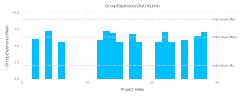

In [127]:
p1 = plot(layer(x=[0, PROJECT_NUM], y=[maximum(exp_1 * beta_1 + exp_2 * beta_2),
                                       maximum(exp_1 * beta_1 + exp_2 * beta_2)],
                Geom.line(), Theme(default_color="pink", line_style=:dash, line_width=2px)),
          layer(x=[0, PROJECT_NUM], y=[minimum(exp_1 * beta_1 + exp_2 * beta_2),
                                       minimum(exp_1 * beta_1 + exp_2 * beta_2)],
                Geom.line(), Theme(default_color="pink", line_style=:dash, line_width=2px)),
          layer(x=[0, PROJECT_NUM], y=[mean(exp_1 * beta_1 + exp_2 * beta_2),
                                       mean(exp_1 * beta_1 + exp_2 * beta_2)],
                Geom.line(), Theme(default_color="pink", line_style=:dash, line_width=2px)),
          layer(x=[PROJECT_NUM, PROJECT_NUM, PROJECT_NUM],
                y=[maximum(exp_1 * beta_1 + exp_2 * beta_2),
                   minimum(exp_1 * beta_1 + exp_2 * beta_2),
                   mean(exp_1 * beta_1 + exp_2 * beta_2),],
                label=["Individual Max", "Individual Min", "Individual Mean"],
                Geom.label(position=:right)),
          layer(df, x="group_num", y="mean", Geom.bar),
          Coord.cartesian(xmin=0, xmax=PROJECT_NUM+5),
          Guide.xlabel("Project Index"), Guide.ylabel("Group Experience Mean"),
          Guide.title("Group Experience Distribution")
        )

draw(SVG(25cm, 10cm), p1)

From the plot above, we can see the relaxed approach to control experience equality is working. Compared to the overall range of individual combined experience level, the mean experience of groups is constrained in a reasonable region. One could further decrease $\delta_1$ to make the distribution more even. We also see only few means are closed to the individual mean. It could imply this constraint is very sensitive (not slack).

In [34]:
results["results"]

Dict{Any,Any} with 4 entries:
  "equality"       => Dict{String,Any}(Pair{String,Any}("beta_1", 1),Pair{Strin…
  "combined_5_0.5" => Dict{String,Any}(Pair{String,Any}("beta_1", 1),Pair{Strin…
  "combined_5_05"  => Dict{String,Any}(Pair{String,Any}("beta_1", 1),Pair{Strin…
  "happy"          => Dict{String,Any}(Pair{String,Any}("beta_1", nothing),Pair…

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.


In this project, we have demonstrated how to use an optimization model to solve a real-life group assignment problem. We also illustrated the model design process through variable determination, data manipulation and constraint/objective transformation. We found the "tricks" we have seen in CS 524 comes very handy, such as logical constraints, relaxation, trade-off, weighting. 

Using the trade-off plot, we have shown there is indeed an trade-off relationship between student happiness and group experience fairness. Through constraint and objectives design, we made this model flexible such that instructors can control all the weights for objectives and each single factors.

One limitation is that we didn't really optimize the group fairness. In other words, the group experience equality is controlled by parameter $\delta_2$, which itself can be an optimization variable. Even though in most cases it is good enough to limit the group experience variance. We still think that there might be a more clever way to modify the variance-based objective, so that we can really find the minimum various solution. It can be a follow-up problem for this project.

## 6. Appendix

### 6.1 Demo data generation

The real data of CS506 student are confidential, so we have to generate simulation data manually. According to Professor Ben Liblit (instructor of CS506 in 2018 Spring), there are 90 students and 29 available projects during the billing phase. We will simulate the survey, and construct $\mathcal{I}, \mathcal{J}, F_w, F_1, F_2, \dots, F_5$ below. 

In [5]:
using StatsBase, Gadfly, DataFrames, JLD

STUDENT_NUM = 90
PROJECT_NUM = 29;

- Generate labels for students $\left(\mathcal{I}\right)$ and projects$\left(\mathcal{J}\right)$. We just use integer index here. Also, we uniform randomly assign project writers to projects $\left(\mathcal{F_w}\right)$.

In [6]:
students = [i for i in 1:STUDENT_NUM]
projects = [j for j in 1:PROJECT_NUM]
project_writers = shuffle(students)[1:PROJECT_NUM];

- There are five levels of experience level, noted as $1,2,3,4,5$. One can argue the programming experience of CS506 students are normally distributed with mean $3$, and rounded into those five discrete values. However, the rounded normal is actually not normal, and the variance is hard to determine without any prior information. Therefore, it is reasonable to self-define a probability mass function and sample from it. Assume the probability of getting $1,2,3,4,5$ is $0.1, 0.2, 0.35, 0.25, 0.1$ respectively for both experience levels.

In [13]:
# Random sampling from the PMF
exp_1 = wsample([1,2,3,4,5], [0.1, 0.2, 0.25, 0.35, 0.1], STUDENT_NUM)
exp_2 = wsample([1,2,3,4,5], [0.1, 0.2, 0.25, 0.35, 0.1], STUDENT_NUM);

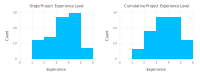

In [14]:
# Visualize the sampling, the distribution is reasonable
df = DataFrame(exp_1 = exp_1, exp_2 = exp_2);
p1 = plot(df, x="exp_1", Geom.histogram(bincount=5), Guide.title("Single Project Experience Level"),
                Guide.xlabel("Experience"), Guide.ylabel("Count"))
p2 = plot(df, x="exp_2", Geom.histogram(bincount=5), Guide.title("Cumulative Project Experience Level"),
                Guide.xlabel("Experience"), Guide.ylabel("Count"))
draw(SVG(20cm, 8cm), hstack(p1, p2))

- Each student can list and sort at most $8$ unique projects he/she wants to work on. All non-listed projects are treated equally.

    It is hard to simulate student's preference of projects, but we should not leave it random (some projects are indeed more popular than others). One heuristic is to assume there are three types of students in CS 506: mobile application fan, web development fan, and others. We assume among each group of students, they share the same interest (probability) of different projects. Therefore, we can define three PMF's then partition students and sample their preference. <br><br>
    
    - Samples are weighted, so the more interested projects are more likely to be sampled at the front of list.
    - We add $0$ as a project, and we stop sampling when $0$ is sampled in the current student's list.
    - The PMF definition is based on my subjective classification of 29 projects of CS506 Spring 2018.
    - Suppose each group has one third of the students
    - Suppose the proposal writer would list his/her own project in the top3 most interested projects.

In [ ]:
# The first ticket is for project 0 (stop listing)
pmf_app = [1, 2, 10, 8, 1, 10, 9, 7, 7, 9, 9, 9, 3, 3, 7, 10, 5, 2, 10, 5, 3, 2, 8, 4, 1, 1, 0, 0, 8, 7]
pmf_web = [1, 5, 2, 5, 8, 2, 5, 1, 1, 1, 2, 3, 9, 9, 5, 2, 2, 9, 1, 9, 7, 10, 2, 10, 8, 9, 8, 8, 5, 3]
pmf_others = vcat([0], [5 for i in 1:29]);

# Sampling
preference = Array{Int64, 2}(STUDENT_NUM, 8);

# Students who like apps
for i in 1:floor(Int, 1/3*STUDENT_NUM)
    temp_sample = wsample([i for i in 0:29], pmf_app, 8, replace=false)
    
    # check if 0 is in the sampling, if so make all the following samples 0
    for j in 1:8
        if temp_sample[j] == 0
            temp_sample[j:end] = 0
            break
        end
    end
    
    preference[i,:] = temp_sample
end

# Students who like webs
for i in floor(Int, 1/3*STUDENT_NUM) + 1 : floor(Int, 2/3*STUDENT_NUM)
    temp_sample = wsample([i for i in 0:29], pmf_web, 8, replace=false)
    
    # check if 0 is in the sampling, if so make all the following samples 0
    for j in 1:8
        if temp_sample[j] == 0
            temp_sample[j:end] = 0
            break
        end
    end
    
    preference[i,:] = temp_sample
end

# Other students
for i in floor(Int, 2/3*STUDENT_NUM) + 1 : STUDENT_NUM
    temp_sample = wsample([i for i in 0:29], pmf_web, 8, replace=false)
    
    # check if 0 is in the sampling, if so make all the following samples 0
    for j in 1:8
        if temp_sample[j] == 0
            temp_sample[j:end] = 0
            break
        end
    end
    
    preference[i,:] = temp_sample
end

# The generation is ordered, so we shuffle the rows
preference = preference[shuffle(1:end), :];

In [167]:
# Assume proposal writer would put his/her own proposal in top 3
for i in 1:STUDENT_NUM
    if(i in project_writers)
        index = findin(project_writers, i)[1]
        # Randomly choose rank 1/2/3
        rank = rand([1,2,3])
        # Check if his/her project is already choosen by him/her
        # If so, just swap it with rank
        original_rank = findin(index, preference[i,:])
        if(original_rank != 0)
            preference[i, original_rank] = preference[i, rank]
        end
        preference[i, rank] = index
    end
end

In [168]:
head(DataFrame(preference))

,x1,x2,x3,x4,x5,x6,x7,x8
1,14,19,25,11,17,24,12,29
2,28,25,20,27,17,21,26,12
3,21,12,20,27,4,23,25,28
4,3,27,25,28,24,26,15,14
5,20,14,4,22,25,3,17,23
6,7,29,11,9,24,10,2,3


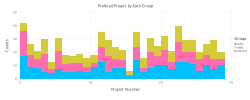

In [17]:
# Visualize the sampling
cut_1 = floor(Int, 1/3*STUDENT_NUM)
cut_2 = floor(Int, 2/3*STUDENT_NUM)
df = DataFrame(app = vcat([preference[r,:] for r in 1:cut_1]...),
               web = vcat([preference[r,:] for r in cut_1+1:cut_2]...),
               others = vcat([preference[r,:] for r in cut_2+1:STUDENT_NUM]...));
df_2 = stack(df, [:app, :web, :others])
p1 = plot(df_2, x="value", color="variable", Geom.histogram, Guide.title("Prefered Project by Each Group"),
            Guide.xlabel("Project Number"), Guide.ylabel("Counts"), Guide.colorkey(title="Group"))
draw(SVG(25cm, 10cm), p1)

We can see the sampling is not totally random. There are some popular projects among three groups, and there are projects only one group really likes. Although this sampling is not perfect, we will use it for the optimization problem.

The next step is to transfer the mapping to the discussed [format](#happiness) of $F_3 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{I} \Vert}\left(\beta_3\right)$. Since $\beta_3$ is a model parameter, we just define a function and use it to convert in the solution section.

In [12]:
# Convert preference from STUDENT_NUM*8 integer matrix to a STUDENT_NUM*PROJECT_NUM
# binary matrix weighted by β3
# β3 is a length 8 vector
function vectorize_f3(preference, β3)
    project_rank = convert(Array{Int64,2}, zeros(STUDENT_NUM,PROJECT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:8
            # If the student did't fill the list full
            if preference[r,c] == 0
                break
            end
            project_rank[r,preference[r,c]] = β3[c]
        end
    end
    return project_rank
end

vectorize_f3 (generic function with 1 method)

In [19]:
# Test the conversion
test_β3 = [8,7,6,5,4,3,2,1]
println("The size of f_3 is $(size(vectorize_f3(preference, test_β3))), the first 6 rows of f_3 is:")
head(DataFrame(vectorize_f3(preference, test_β3)))

The size of f_3 is (90, 29), the first 6 rows of f_3 is:


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29
1,0,6,0,0,0,0,0,0,0,0,5,2,0,8,0,0,4,0,7,0,0,0,0,3,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,6,3,0,0,0,7,2,5,8,0
3,0,0,0,4,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,6,8,0,3,0,2,0,5,1,0
4,0,0,8,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,4,6,3,7,5,0
5,0,0,3,6,0,0,0,0,0,0,0,0,0,7,0,0,2,0,0,8,0,5,1,0,4,0,0,0,0
6,0,2,1,0,0,0,8,0,5,3,6,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,7


- Finally, we can generate student's preference to each other. It is a social network generation problem, and can be very hard without prior information.
    
    This heuristic is not perfect, but I think it is good enough for this optimization modeling:
    1. We assume three fifth of the students enroll CS506 without knowing anyone, and the others enroll in the form of circles of friends. 
    2. We assume we have a probability of $0.1, 0.2, 0.7$ to see friend size $7, 5, 3$, and each circle of friends are disconnected from other circles.
    3. For a student enrolled alone, he/she has a low probability to "like" or "dislike" any other students.
    4. For a student enrolled with his/her friends, he/she has a high probability to "like" people from his/her friends, and a low probability to "like" or "dislike" anyone else.
    5. Alone student's choice is not independent. If he/she is "liked" by someone else, then he/she has a higher probability to "like" (not "dislike") that person back. We assume students with friends chooses independently.
    6. We assume each student would not "dislike" the one he/she "likes" or his/her friends.

In [20]:
# If see one zero, then just fill all the left as zero
# (this student didn't fill all of the list)
function clean_zeros(sampled)
    for i in 1:length(sampled)
        if sampled[i] == 0
            sampled[i:end] = 0
            break
        end
    end
    return sampled
end

# Choose group size 7,5,3 with probability 0.1, 0.2, 0.7
function get_group_size()
    flip = rand()
    if flip < 0.1
        return 7
    elseif flip < 0.3
        return 5
    else
        return 3
    end
end

get_group_size (generic function with 1 method)

In [21]:
likes = convert.(Int, zeros(STUDENT_NUM, 3))
dislikes = convert.(Int, zeros(STUDENT_NUM, 2))

# Partition students and assign probabilities
pmfs = zeros(STUDENT_NUM, STUDENT_NUM + 1)
shuffled_students = shuffle([1:STUDENT_NUM]...)
options = [0:STUDENT_NUM...]

# Alone student's init pmf is [90, 1, 1, 1, 1, ....] for example
alone_student_init_pmf = vcat([STUDENT_NUM], [1 for in in 1:STUDENT_NUM])

# Each student has 1/6 probability to have someone he/she deosnt want to work with
dislike_pmf = vcat([5 * STUDENT_NUM], [1 for in in 1:STUDENT_NUM]);

no_need_friends = Set(sample([1:STUDENT_NUM...], floor(Int, 3 * STUDENT_NUM/5), replace=false))
need_friends = setdiff(Set(1:STUDENT_NUM), no_need_friends);

In [22]:
print("$(length(collect(need_friends))) students need friends!")
for i in shuffled_students
    if i in no_need_friends
        # Update student's pmf
        pmfs[i,:] = pmfs[i,:] + alone_student_init_pmf
        pmfs[i,i] = 0
        
        # Sample his preference
        like = wsample(options, pmfs[i,:], 3, replace=false)
        like = clean_zeros(like)
        
        # He cannot dislike the one he likes
        cur_dislike_pmf = copy(dislike_pmf)
        cur_dislike_pmf[filter(x->x!=0, like)] = 0
        dislike = wsample(options, cur_dislike_pmf, 2, replace=false)
        dislike = clean_zeros(dislike)
        
        # Update the liked student's pmf
        for l in like
            if l == 0
                break
            end
            # Gaurantee at least 1/2 probability to like back
            pmfs[l, i+1] = pmfs[l, i+1] + STUDENT_NUM
        end
        
        # Update the global preference matrix
        likes[i,:] = like
        dislikes[i,:] = dislike
    
    else
        print(" → $(length(collect(need_friends)))")
        # The other half of the students
        # Check if he has already been asigned of friends, if not, assign to him
        if i in need_friends
            setdiff!(need_friends, [i])
            g_size = get_group_size()
            
            # Randomly choose friends for him
            friends = vcat([i], sample(collect(need_friends),
                    minimum([g_size - 1, length(collect(need_friends))]), replace=false))
            setdiff!(need_friends, friends)
            
            # They share the same "liking" pmf
            friend_pmf = copy(alone_student_init_pmf)
            friend_pmf[1] = 1
            friend_pmf[vcat([i], friends)+1] = STUDENT_NUM
            for f in friends
                pmfs[f,:] = friend_pmf
            end
        end
        
        friends = [j-1 for j in 2:STUDENT_NUM+1 if pmfs[i,j] > 2]
        
        # Sample preference for him
        like = wsample(options, pmfs[i,:], 3, replace=false)
        like = clean_zeros(like)
        
        # He cannot dislike the one he likes and his friends
        cur_dislike_pmf = copy(dislike_pmf)
        cur_dislike_pmf[filter(x->x!=0, like)] = 0
        cur_dislike_pmf[friends] = 0
        dislike = wsample(options, cur_dislike_pmf, 2, replace=false)
        dislike = clean_zeros(dislike)
        
        # Update the global preference matrix
        likes[i,:] = like
        dislikes[i,:] = dislike
    end
end

36 students need friends! → 36 → 33 → 28 → 28 → 28 → 25 → 20 → 13 → 10 → 10 → 10 → 3 → 3 → 3 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0 → 0

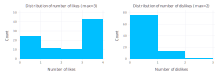

In [28]:
# Visualize the friends count distribution
my_count = x -> 0 in x ? (length(x) - countmap(x)[0]) : length(x)
like_num = []
dislike_num = []
for i in 1:STUDENT_NUM
    push!(like_num, my_count(likes[i,:]))
    push!(dislike_num, my_count(dislikes[i,:]))
end

df = DataFrame(like_num=like_num, dislike_num=dislike_num)
p1 = plot(df, x="like_num", Geom.histogram(bincount=4), Guide.title("Distribution of number of likes (max=3)"),
            Guide.xlabel("Number of likes"), Guide.ylabel("Count"))
p2 = plot(df, x="dislike_num", Geom.histogram(bincount=3), Guide.title("Distribution of number of dislikes (max=2)"),
            Guide.xlabel("Number of dislikes"), Guide.ylabel("Count"))
draw(SVG(22cm, 8cm), hstack(p1, p2))

The distribution looks reasonable. Then we need to transfer student's partner preference into the [format](#f4) of $F_4 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{I} \Vert}\left(\beta_4\right), F_5 \in M_{\Vert \mathcal{I} \Vert \times \Vert \mathcal{I} \Vert}\left(\beta_5\right)$. Since parameter $\beta_4, \beta_5$ may change, we just define the convert functions here.

In [13]:
# Convert preference from STUDENT_NUM*3 integer matrix to a STUDENT_NUM*STUDENT_NUM
# binary matrix weighted by β4
# β4 is a length 3 vector
function vectorize_f4(likes, β4)
    student_likes = convert(Array{Int64,2}, zeros(STUDENT_NUM,STUDENT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:3
            # If the student did't fill the list full
            if likes[r,c] == 0
                break
            end
            student_likes[r, likes[r,c]] = β4[c]
        end
    end
    return student_likes
end

# Convert preference from STUDENT_NUM*2 integer matrix to a STUDENT_NUM*STUDENT_NUM
# binary matrix weighted by β5
# β5 is a length 2 vector
function vectorize_f5(dislikes, β5)
    student_dislikes = convert(Array{Int64,2}, zeros(STUDENT_NUM,STUDENT_NUM))
    for r in 1:STUDENT_NUM
        for c in 1:2
            # If the student did't fill the list full
            if dislikes[r,c] == 0
                break
            end
            student_dislikes[r, dislikes[r,c]] = β5[c]
        end
    end
    return student_dislikes
end

vectorize_f5 (generic function with 1 method)

In [30]:
# Test the conversion
test_β4 = [3, 2, 1]
println("The size of f_4 is $(size(vectorize_f4(likes, test_β4))), the first 6 rows of f_3 is:")
head(DataFrame(vectorize_f4(likes, test_β4)))

The size of f_4 is (90, 90), the first 6 rows of f_3 is:


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


Then, we want to store the generated data to make the modeling consistent.

In [169]:
#save("data.jld", "project_writers", project_writers,
#     "exp_1", exp_1, "exp_2", exp_2,
#     "preference", preference, "likes", likes,
#     "dislikes", dislikes)